<a href="https://colab.research.google.com/github/hirokimituya/book_create-profitable-AI-with-Python/blob/main/ch05_03_bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.3 季節など周期性で売り上げ予測(時系列分析)



In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

## 5.3.4 データ読み込みからデータ確認まで

In [3]:
# ダウンロード元URL
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 公開データのダウンロードと解凍
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

--2023-03-24 09:39:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.04s   

2023-03-24 09:39:07 (6.88 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

  inflating: hour.csv                


In [4]:
# day.csvをデータフレームに取り込み
# 日付を表す列はparse_datesで指定する
df = pd.read_csv('day.csv', parse_dates=[1])

In [5]:
# instant は連番で予測で不要なので削除
df = df.drop('instant', axis=1)

# 項目名の日本語化

columns = [
    '日付',  '季節',  '年', '月', '祝日', '曜日', '勤務日', '天気', 
    '気温', '体感温度',  '湿度', '風速',
    '臨時ユーザー利用数', '登録ユーザー利用数', '全体ユーザー利用数'
]

# 項目名を日本語に置き換え
df.columns = columns

In [6]:
# 先頭5行の確認
display(df.head())

# 最終5行の確認
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


## 5.3.5 データ前処理とデータ分割

In [7]:
# 「日付」と「登録ユーザー利用数」のみ抽出し、
# 列名を日付: ds、登録ユーザー利用数: yに置き換えたデータフレームdf2を作る

# データフレーム全体のコピー
df2 = df.copy()

# 「日付」「登録ユーザー利用数」列の抽出
df2 = df2[['日付', '登録ユーザー利用数']]

# 列名の置き換え
df2.columns = ['ds', 'y']

# 結果確認
display(df2.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


In [8]:
# 分割日mdayの設定
mday = pd.to_datetime('2012-11-1')

# 訓練用indexと検証用indexを作る
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# 入力データの分割
x_train = df2[train_index]
x_test = df2[test_index]

# 日付データの分割（グラフ表示用）
dates_test = df2['ds'][test_index]

## 5.3.6 アルゴリズム選択

In [9]:
# ライブラリのimport
from prophet import Prophet

# モデル選択
# 三つのseasonalityパラメータの設定が重要
# 今回のデータの場合、日単位のデータなのでdaily_seasonalityは不要
# weekly_seasonalityとdaily_seasonalityは
# True / Falseの他に数値で指定することも可能（三角関数の個数）
# seasonality_mode: additive（デフォルト）multiplicative

m1 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
             seasonality_mode='multiplicative')

## 5.3.7 学習・予測

In [10]:
# 学習
m1.fit(x_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi1zsd085/jep8kjcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi1zsd085/bkflrejn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28840', 'data', 'file=/tmp/tmpi1zsd085/jep8kjcm.json', 'init=/tmp/tmpi1zsd085/bkflrejn.json', 'output', 'file=/tmp/tmpi1zsd085/prophet_modeltwm1jier/prophet_model-20230324093909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:39:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
# 予測用データの作成
# （日付dsだけの入ったデータフレーム）
# 61は予測したい日数（2011-11-1から2012-12-31）
future1 = m1.make_future_dataframe(periods=61, freq='D')

# 結果確認
display(future1.head())
display(future1.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [12]:
# 予測
# 結果はデータフレームで戻ってくる
fcst1 = m1.predict(future1)

 ## 5.3.8 評価

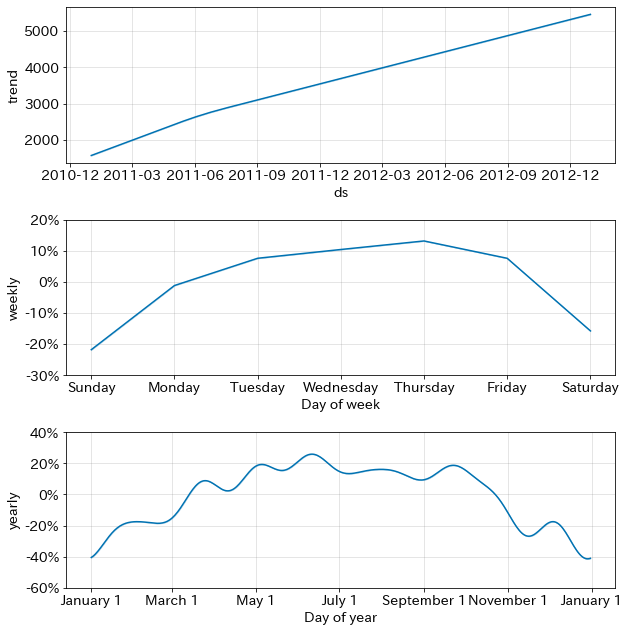

In [13]:
# 要素ごとのグラフ描画
# この段階ではトレンド、週周期、年周期
fig = m1.plot_components(fcst1)
plt.show()

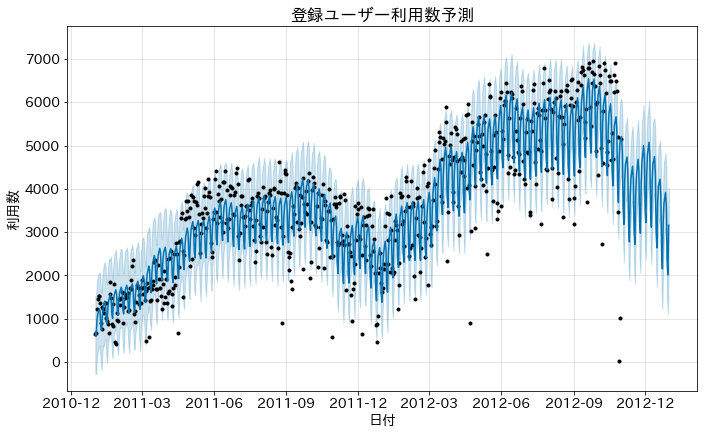

In [14]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(10, 6))

# 予測結果のグラフ表示（prophetの関数）
m1.plot(fcst1, ax=ax)

# タイトル設定など
ax.set_title('登録ユーザー利用数予測')
ax.set_xlabel('日付')
ax.set_ylabel('利用数')

# グラフ表示
plt.show()

In [15]:
# ypred1: fcst1から予測部分のみ抽出する
ypred1 = fcst1[-61:][['yhat']].values

# ytest1: 予測期間中の正解データ
ytest1 = x_test['y'].values

# R2値の計算
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

# 結果確認
print(f'R2 score:{score:.4f}')

R2 score:0.3736


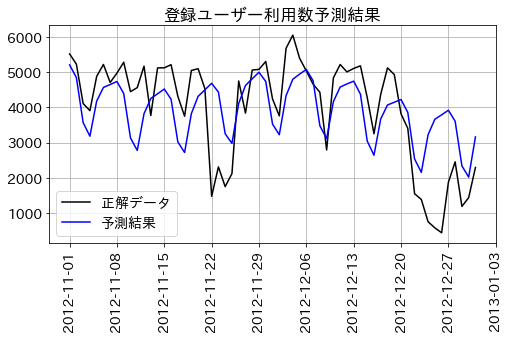

In [16]:
# 時系列グラフの描画
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='k')
ax.plot(dates_test, ypred1, label='予測結果', c='b')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果')

# 画面出力
plt.show()

## 5.3.9 チューニング（ステップ1）

In [19]:
# 休日の抽出
df_holiday = df[df['祝日'] == 1]
holidays = df_holiday['日付'].values

# データフレーム形式に変換
df_add = pd.DataFrame({'holiday': 'holi',
                       'ds': holidays,
                       'lower_window': 0,
                       'upper_window': 0
})

#　結果確認
display(df_add.head())
display(df_add.tail())

,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


In [20]:
# 休日（df_add）をモデルの入力とする

# アルゴリズム選択
# holidaysパラメータンを追加してモデルm2を生成
m2 = Prophet(yearly_seasonality=True,
             weekly_seasonality=True, daily_seasonality=False,
             holidays=df_add, seasonality_mode='multiplicative')

# 学習
m2 = m2.fit(x_train)

# 予測
fcst2 = m2.predict(future1)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi1zsd085/hk691mdp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi1zsd085/ge1_frls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16508', 'data', 'file=/tmp/tmpi1zsd085/hk691mdp.json', 'init=/tmp/tmpi1zsd085/ge1_frls.json', 'output', 'file=/tmp/tmpi1zsd085/prophet_modelvzj6rhv8/prophet_model-20230324101825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## 5.3.10 チューニング（ステップ2）

In [21]:
# 学習データに「天気」「気温」「風速」「湿度」を追加
df3 = pd.concat([df2, df[['天気', '気温', '風速', '湿度']]], axis=1)

# 入力データの分割
x2_train = df3[train_index]
x2_test = df3[test_index]

# 結果確認
display(x2_train.tail())

,ds,y,天気,気温,風速,湿度
665,2012-10-27,5209,2,0.5300,0.2357,0.7200
666,2012-10-28,3461,2,0.4775,0.3980,0.6946
667,2012-10-29,20,3,0.4400,0.3582,0.8800
668,2012-10-30,1009,2,0.3182,0.2130,0.8255
669,2012-10-31,5147,2,0.3575,0.1667,0.6667


In [22]:
# アルゴリズム選択

m3 = Prophet(yearly_seasonality=True,
             weekly_seasonality=True,
             daily_seasonality=False,
             seasonality_mode='multiplicative',
             holidays=df_add)

# add_regressor関数で「天気」「気温」「風速」「湿度」をモデルに組み込む
m3.add_regressor('天気')
m3.add_regressor('気温')
m3.add_regressor('風速')
m3.add_regressor('湿度')

# 学習
m3.fit(x2_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi1zsd085/jy2779uz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi1zsd085/tcqvr2of.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4788', 'data', 'file=/tmp/tmpi1zsd085/jy2779uz.json', 'init=/tmp/tmpi1zsd085/tcqvr2of.json', 'output', 'file=/tmp/tmpi1zsd085/prophet_modelxutg8b44/prophet_model-20230324102606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:26:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:26:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
# 予測用の入力データを作る
future3 = df3[['ds', '天気', '気温', '風速', '湿度']]

# 予測
fcst3 = m3.predict(future3)